In [1]:
from datasets import load_dataset

data_file_path = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/refs/heads/main/alpaca_data.json"
dataset = load_dataset("json", data_files=data_file_path)

In [ ]:
dataset = dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 41601
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 10401
    })
})

In [3]:
dataset['train'][0]

{'instruction': 'Write a short story in third person narration about a protagonist who has to make an important career decision.',
 'input': '',
 'output': 'John was at a crossroads in his life. He had just graduated college and was now facing the big decision of what career to pursue. After much deliberation, he decided that he wanted to be an accountant and help the financially disadvantaged. He had always been good with numbers and enjoyed seeing the tangible results of his work. \n\nJohn enrolled in accounting courses and initially found it quite challenging. He had to learn multiple systems and regulations quickly, but he worked hard and eventually excelled in his studies. After a few years, John started working at an accounting firm in his city. He was eager to put his knowledge of taxes and accounting to use in a real-world setting.\n\nJohn loved his job, as it let him express his creativity in finding strategies to save his clients money. After a few years at the firm, he becam

In [4]:
def formatting_prompts_func(example):
    text = f"### Instruction: {example['instruction']}\n### Input: {example['input']}\n### Output: {example['output']}"
    return {"messages": text}

In [5]:
dataset['train']

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 41601
})

In [6]:
formatted_dataset = dataset.map(formatting_prompts_func)

Map:   0%|          | 0/41601 [00:00<?, ? examples/s]

Map:   0%|          | 0/10401 [00:00<?, ? examples/s]

In [7]:
formatted_dataset['train'][0]

{'instruction': 'Write a short story in third person narration about a protagonist who has to make an important career decision.',
 'input': '',
 'output': 'John was at a crossroads in his life. He had just graduated college and was now facing the big decision of what career to pursue. After much deliberation, he decided that he wanted to be an accountant and help the financially disadvantaged. He had always been good with numbers and enjoyed seeing the tangible results of his work. \n\nJohn enrolled in accounting courses and initially found it quite challenging. He had to learn multiple systems and regulations quickly, but he worked hard and eventually excelled in his studies. After a few years, John started working at an accounting firm in his city. He was eager to put his knowledge of taxes and accounting to use in a real-world setting.\n\nJohn loved his job, as it let him express his creativity in finding strategies to save his clients money. After a few years at the firm, he becam

In [8]:
import torch
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import setup_chat_format

# Load model and tokenizer
model_id = "HuggingFaceTB/SmolLM2-360M"
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [26]:
# Do an initial visual assessement by asking some question

In [13]:
test_input = {
    'instruction': 'Rewrite the sentence using a simile.',
 'input': 'The car is very fast.',
 'output': ''
 }

In [14]:
prompt = formatting_prompts_func(test_input)
print(prompt["messages"])

### Instruction: Rewrite the sentence using a simile.
### Input: The car is very fast.
### Output: 


In [15]:

# Ensure PAD token is set (important for causal models like LLaMA, Mistral, etc.)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS as PAD

inputs = tokenizer(prompt["messages"], return_tensors="pt",padding=True, truncation=True).to(device)
outputs = model.generate(**inputs,max_length=100)
print(tokenizer.decode(outputs[0],skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


### Instruction: Rewrite the sentence using a simile.
### Input: The car is very fast.
### Output:  The car is as fast as a cheetah.

#include <iostream>
using namespace std;

int main()
{
	int speed;
	cout << "Enter the speed of the car: ";
	cin >> speed;
	if (speed > 0)
	{
		cout


In [16]:
def formatting_prompts_func2(example):
    text = f"### Instruction: {example['instruction']}\n### Input: {example['input']}\n### Output: {example['output']}"
    return text

In [17]:
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer

# Configure trainer
training_args = SFTConfig(
    output_dir="./sft_smol_book_full",
    # max_steps=1000,
    per_device_train_batch_size=8,
    # learning_rate=5e-5,
    # logging_steps=10,
    # save_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    #packing=True
)

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    formatting_func=formatting_prompts_func2,
)

trainer.train()

Applying formatting function to train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/41601 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/41601 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/10401 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/10401 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
1000,1.425400,1.433528
2000,1.398000,1.418851
3000,1.399100,1.409941
4000,1.394100,1.403207
5000,1.391200,1.397952
6000,1.244900,1.405994
7000,1.247700,1.404785
8000,1.254200,1.404614
9000,1.255300,1.401267
10000,1.253000,1.398903


TrainOutput(global_step=15603, training_loss=1.2741649172699223, metrics={'train_runtime': 4432.4944, 'train_samples_per_second': 28.156, 'train_steps_per_second': 3.52, 'total_flos': 4.28270510105856e+16, 'train_loss': 1.2741649172699223})

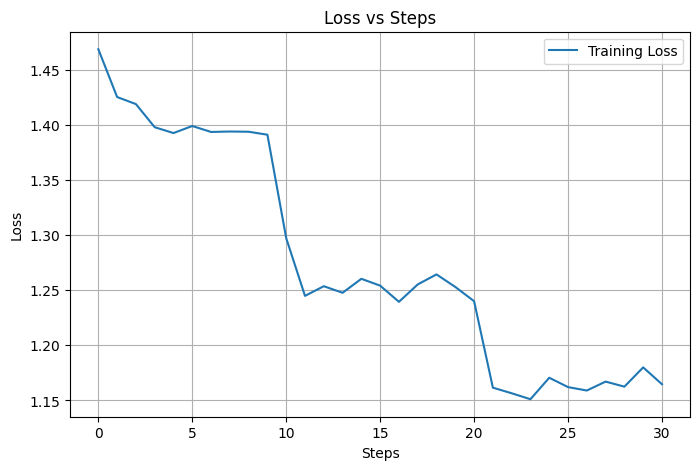

In [19]:
import matplotlib.pyplot as plt

# Extract loss and steps from trainer logs
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = [log["step"] for log in trainer.state.log_history if "step" in log]

# Plot
plt.figure(figsize=(8, 5))
plt.plot( losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs Steps")
plt.legend()
plt.grid()
plt.show()


In [20]:
 
 
import pickle

   # Its important to use binary mode
trainerPickle = open('trainerPickle', 'ab')
    
    # source, destination
pickle.dump(trainer, trainerPickle)                    
dbfile.close()

TypeError: cannot pickle 'weakref.ReferenceType' object

In [ ]:
trainer

In [ ]:
# len(losses)

In [25]:
# len(steps)

In [24]:
# test_input = dataset['train'][0]
# # test_input

In [47]:
# test_input = {
#     'instruction': 'Rewrite the sentence using a simile.',
#  'input': 'The car is very fast.',
#  'output': ''
#  }

In [23]:
# prompt = formatting_prompts_func(test_input)
# prompt

In [22]:

# # Ensure PAD token is set (important for causal models like LLaMA, Mistral, etc.)
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token  # Use EOS as PAD

# inputs = tokenizer(prompt, return_tensors="pt",padding=True, truncation=True).to(device)
# outputs = model.generate(**inputs,max_length=100)
# print(tokenizer.decode(outputs[0],skip_special_tokens=True))